# Recurrent Neural Networks with Pytorch

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from IPython.display import Image

## LSTM Network

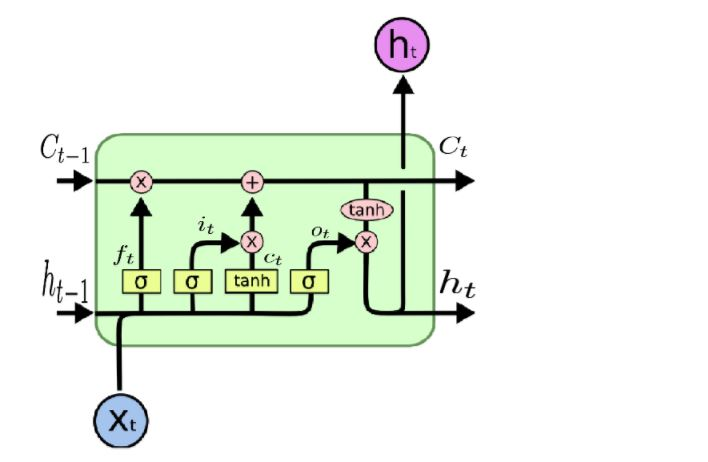

In [3]:
Image('https://www.stratio.com/wp-content/uploads/2017/10/6-1.jpg')

In brief, there is an operation to forget the old outputput based on the new input. There is an operation to generate new output based on the hidden state and the new input. There is an operation to incorporate the new output into in the new hidden state.

## Encoder - Decoder Network

Basically put two LSTM cells on top of each other. You can convert one sequence into another sequence and this has a particular natural anology in translation. The encoded output of the network is the 'meaning' of the words and the decoded output is the translation.

We can deal the inputs and outputs of variable length by using a start token and an end token.

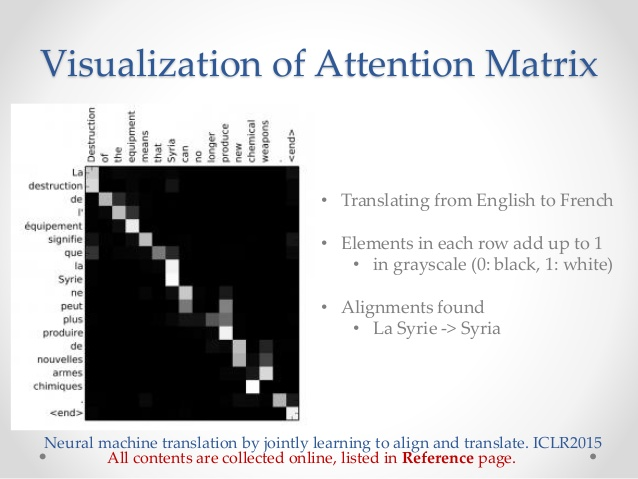

In [4]:
Image('https://image.slidesharecdn.com/rnnintro2-161020134201/95/a-brief-introduction-on-recurrent-neural-network-and-its-application-20-638.jpg')

This kind of alignment matrix will tell us what is activated in the output compared what the input was. Plus in french can mean 'more' or 'no longer' or 'longer' or 'add'. We see that produire has a direct translation and therefore gets a stronger activation than plus gets from the same word.

Likewise, predicting words from an image should give an activation on the parts of the image that contribute to that prediction.

Attention is where we use the input encoder LSTM layers to process some encoded input and concatenate it with a hidden state which is passed to the output LSTM cells. Every time an output LSTM decodes some output, we take an operator which does element wise multiplication with the compressed representation of the encoding LSTM cells.

## Reading in movie data

In [5]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb

In [6]:
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [7]:
assert(unicodeToAscii('Montréal') == 'Montreal')

In [8]:
cwd = 'D:/Pytorch Data/cornell_movie_dialogs/'

In [9]:
lines_path = cwd + 'movie_lines.txt'
conv_path = cwd + 'movie_conversations.txt'

In [10]:
with open(lines_path) as file:
    movie_lines = file.readlines()
for line in movie_lines[:8]:
    print(line)

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!

L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!

L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.

L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?

L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.

L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow

L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.

L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No



In [11]:
def extractSplitLine(split_line, line_fields, first_col_id = False):
    if len(split_line) != len(line_fields):
        print('Warning: line', split_line, 'is the wrong length!')
        return
    line_dict = {}
    line_pos = 1 if first_col_id else 0
    for field in line_fields[line_pos:]:
        line_dict[field] = split_line[line_pos]
        line_pos += 1
    return line_dict

def convertLinesToDfs(line_fields, input_lines, separator, first_col_id = False): # boolean makes function dirty
    data_lines = {}
    line_id = 0
    for line in input_lines:
        split_line = line.split(separator)
        line_id = split_line[0] if first_col_id else line_id + 1
        line_dict = extractSplitLine(split_line, line_fields, first_col_id)
        if not line_dict: continue
        data_lines[line_id] = line_dict
    return pd.DataFrame.from_dict(data_lines, orient = 'index')

In [12]:
line_fields = ["lineId", "charId", "movieId", "charName", "text"]
separator = " +++$+++ "
movie_line_df = convertLinesToDfs(line_fields, movie_lines, separator, True)
del movie_lines

In [13]:
movie_line_df.head()

,charId,movieId,charName,text
L1000,u11,m0,WALTER,"Oh, Christ. Don't tell me you've changed your..."
L10000,u3525,m232,LINDSEY,"Oh... chamber runs. Uh huh, that's good. Wel..."
L100000,u4168,m278,JOANNE,No.\n
L100001,u4166,m278,DULANEY,Then why did you go see Mr. Koehler in the fir...
L100002,u4168,m278,JOANNE,Because he called me.\n


In [14]:
with open(conv_path) as file:
    conv_lines = file.readlines()
for line in conv_lines[:8]:
    print(line)

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L271', 'L272', 'L273', 'L274', 'L275']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L276', 'L277']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L280', 'L281']



In [15]:
line_fields = ["charId1", "charId2", "movieId", "conversation"]
conv_line_df = convertLinesToDfs(line_fields, conv_lines, separator)
del conv_lines

In [16]:
conv_line_df.head()

,charId1,charId2,movieId,conversation
1,u0,u2,m0,"['L194', 'L195', 'L196', 'L197']\n"
2,u0,u2,m0,"['L198', 'L199']\n"
3,u0,u2,m0,"['L200', 'L201', 'L202', 'L203']\n"
4,u0,u2,m0,"['L204', 'L205', 'L206']\n"
5,u0,u2,m0,"['L207', 'L208']\n"


In [17]:
def processMovieLine(line_string):
    line_string = unicodeToAscii(line_string)
    line_string = line_string.lower()
    line_string = re.sub(r'[ ]', ',', line_string)
    line_string = re.sub(r'[^a-z,!?.]', '', line_string)
    line_string = re.sub(r'[!]', ',!', line_string)
    line_string = re.sub(r'[?]', ',?', line_string)
    line_string = re.sub(r'[.]', ',.', line_string)
    line_string = re.sub(r',,', ',', line_string)
    return line_string.split(',')
processMovieLine(movie_line_df.iloc[5]["text"])

['hi', 'joe', '.']

In [18]:
movie_line_df['text'] = movie_line_df['text'].apply(processMovieLine)

In [19]:
def processConvLine(conv_string):
    conv_string = re.sub(r'[^,A-Za-z0-9]', '', conv_string)
    return conv_string.split(',')
processConvLine(conv_line_df.iloc[5]['conversation'])

['L271', 'L272', 'L273', 'L274', 'L275']

In [20]:
conv_line_df['conversation'] = conv_line_df['conversation'].apply(processConvLine)

In [21]:
def getAllLinesFromConversations(conversation_dict):
    lines_arr = []
    for conv_list in conversation_dict.values():
        lines_arr.extend(conv_list)
    return lines_arr

def fillUpBatchLinePairs(lines_slice, conv_slice, current_id):
    batch_dict = {}
    for conv in conv_slice.values():
        for j in range(len(conv) - 1):
            line_dict = {}
            line_dict['input'] = lines_slice[conv[j]]
            line_dict['truth'] = lines_slice[conv[j + 1]]
            batch_dict[current_id] = line_dict
            current_id += 1
    return current_id, batch_dict

def getBatchRange(i, batch_size, max_len):
    return range(i * batch_size, min((i+1) * batch_size, max_len))

def makeAllConversationPairs(movie_line_df, conv_line_df, batch_size = 100):
    n_conversations = len(conv_line_df.index)
    n_batches = (n_conversations + batch_size - 1) // batch_size
    data_lines = {}
    current_id = 0
    for i in range(n_batches):
        batch_range = getBatchRange(i, batch_size, n_conversations)
        conv_slice = conv_line_df['conversation'].iloc[batch_range].to_dict()
        lines_included = getAllLinesFromConversations(conv_slice)
        lines_slice = movie_line_df['text'].loc[lines_included].to_dict()
        current_id, batch_dict = fillUpBatchLinePairs(lines_slice, conv_slice, current_id)
        data_lines.update(batch_dict)
    return pd.DataFrame.from_dict(data_lines, orient = 'index')

In [22]:
conv_data_df = makeAllConversationPairs(movie_line_df, conv_line_df)

In [23]:
total_len = 0
for conv_list in conv_line_df['conversation']:
    total_len += len(conv_list)
    total_len -= 1
print(total_len)
assert(total_len == len(conv_data_df))

221616


## Process Vocabulary

In [24]:
conv_data_df.head()

,input,truth
0,"[can, we, make, this, quick, ?, roxanne, korri...","[well, i, thought, wed, start, with, pronuncia..."
1,"[well, i, thought, wed, start, with, pronuncia...","[not, the, hacking, and, gagging, and, spittin..."
2,"[not, the, hacking, and, gagging, and, spittin...","[okay, ., ., ., then, how, bout, we, try, out,..."
3,"[youre, asking, me, out, ., thats, so, cute, ....","[forget, it, .]"
4,"[no, no, its, my, fault, we, didnt, have, a, p...","[cameron, .]"


In [25]:
last_train_index = int(len(conv_data_df) * 0.9)

In [26]:
SPAM_TOKEN = 0
END_TOKEN = 1
FLUFF_TOKEN = 2

class Vocabulary:
    def __init__(self, name, last_train, load_size = 100, stop_words = ['.', '?', '!']):
        self.name = name
        self.last_train = last_train
        self.load_size = load_size
        self.stop_words = stop_words
        self.resetDictionaries()
        
    def resetDictionaries(self):
        self.word_2_index = {}
        self.word_2_count = {}
        self.index_2_word = {SPAM_TOKEN:'_spam_', END_TOKEN:'_end_', FLUFF_TOKEN:'_fluff_'}
        self.nr_words = 3
        
    def addEntry(self, entry):
        for word in entry:
            if word in self.word_2_index.keys():
                self.word_2_count[word] += 1
            else:
                self.word_2_index[word] = self.nr_words
                self.index_2_word[self.nr_words] = word
                self.word_2_count[word] = 1
                self.nr_words += 1
            if word in self.stop_words: break
                
    def addAllEntries(self, df, col):
        n_batches = (self.last_train + self.load_size - 1) // self.load_size
        for k in range(n_batches):
            batch_range = getBatchRange(k, self.load_size, self.last_train)
            conv_slice = df[col].iloc[batch_range].to_dict()
            for entry in conv_slice.values():
                self.addEntry(entry)
    
    def countEntry(self, entry):
        entry_count = 0
        for word in entry:
            if word in self.word_2_index.keys():
                entry_count += 1
                if word in self.stop_words: break
        return entry_count
    
    def getLongestSentence(self, df):
        n_batches = (len(df) + self.load_size - 1) // self.load_size
        max_count = 0
        for col in df.columns:
            for k in range(n_batches):
                batch_range = getBatchRange(k, self.load_size, len(df))
                conv_slice = df[col].iloc[batch_range].to_dict()
                for entry in conv_slice.values():
                    entry_count = self.countEntry(entry)
                    if entry_count > max_count: max_count = entry_count
        return max_count
                
    def removeBelowThreshold(self, thresh):
        new_word_2_index = {}
        new_word_2_count = {}
        new_index_2_word = {SPAM_TOKEN:'_spam_', END_TOKEN:'_end_', FLUFF_TOKEN:'_fluff_'}
        k = 3
        current_index = 3
        for k in range(3, self.nr_words):
            word = self.index_2_word[k]
            word_count = self.word_2_count[word]
            if word_count > thresh:
                new_word_2_index[word] = current_index
                new_index_2_word[current_index] = word
                new_word_2_count[word] = word_count
                current_index += 1
        self.word_2_index = new_word_2_index
        self.word_2_count = new_word_2_count
        self.index_2_word = new_index_2_word
        self.nr_words = current_index
        

    
    def plotFrequencyHist(self, cut_off):
        freq_dist = [val for val in self.word_2_count.values() if val < cut_off]
        total_freq = sum(self.word_2_count.values())
        if total_freq > 0: total_freq = sum(freq_dist)/total_freq
        sns.distplot(freq_dist, color='y', kde = False)
        plt.title(label = "Showing {}% of all words".format(np.round(total_freq * 100, 1)))
        plt.show()

In [27]:
cut_off = 4

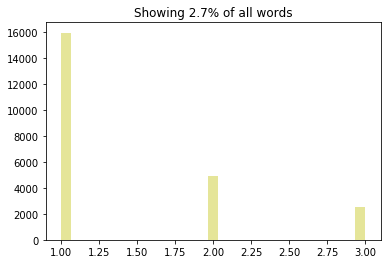

In [28]:
movie_vocab = Vocabulary('MOVIE_CONV', last_train_index)
movie_vocab.addAllEntries(conv_data_df, 'input')
movie_vocab.plotFrequencyHist(cut_off)

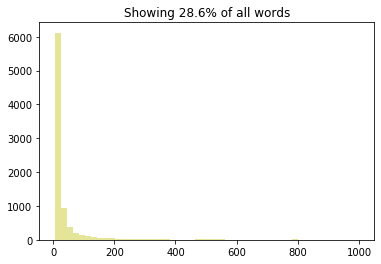

In [29]:
movie_vocab.removeBelowThreshold(cut_off)
movie_vocab.plotFrequencyHist(1000)

In [30]:
vocab_size = movie_vocab.nr_words; print(vocab_size)

8617


In [31]:
longest_sentence = movie_vocab.getLongestSentence(conv_data_df); print(longest_sentence)

104


## Building a batch generator

The previous class is an object that just converts a number into a word we can read and visa versa. This second container class will use the vocabulary to generate batches that the neural network can read.

In [32]:
class ConversationBatchGenerator:
    def __init__(self, vocabulary : Vocabulary, batch_size : int, max_sentence_len: int):
        self.vocab = vocabulary
        self.batch_size = batch_size
        self.max_sentence_len = max_sentence_len
        self.input = torch.zeros((sentence_limit, batch_size), dtype = torch.float32)
        self.input_lens = torch.zeros(batch_size, dtype = torch.int32)
        self.label = torch.zeros((sentence_limit, batch_size), dtype = torch.float32)
        self.label_lens = torch.zeros(batch_size, dtype = torch.int32)

    def tokenizeEntry(self, out_tensor, out_lens, entry, current_ind):
        w_ind = 0
        entry_len = len(entry)
        sentence_len = out_tensor.shape[0]
        while w_ind < sentence_len:
            if not w_ind < entry_len: break
            word = entry[w_ind]
            if word in self.vocab.word_2_count.keys():
                out_tensor[w_ind, current_ind] = self.vocab.word_2_index[entry[w_ind]]
            else:
                out_tensor[w_ind, current_ind] = SPAM_TOKEN
            w_ind += 1
            if word in self.vocab.stop_words: break
        out_lens[current_ind] = w_ind          
        if w_ind < sentence_len:
            out_tensor[w_ind, current_ind] = END_TOKEN
            w_ind += 1
        while w_ind < sentence_len:
            out_tensor[w_ind, current_ind] = FLUFF_TOKEN
            w_ind += 1

    def fillTensorFromDdBatch(self, out_tensor, out_lens, df, batch_range, col):
        df_slice = df[col].iloc[batch_range].to_dict()
        current_ind = 0
        for entry in df_slice.values():
            self.tokenizeEntry(out_tensor, out_lens, entry, current_ind)
            current_ind += 1
            
    def getTokenizedBatch(self, df, start_ind, data_col, label_col = None):
        n_batches = (len(df) + self.batch_size - 1) // self.batch_size
        batch_range = getBatchRange(start_ind, self.batch_size, len(df))
        self.fillTensorFromDdBatch(self.input, self.input_lens, df, batch_range, data_col)
        label_out = None
        label_lens = None
        if label_col:
            self.fillTensorFromDdBatch(self.label, self.label_lens, df, batch_range, label_col)
            label_out = self.label
            label_lens = self.label_lens
        return self.input, self.input_lens, self.label, label_lens 

    def printTensorRow(self, row_ind, in_tensor):
        if row_ind > self.batch_size -1: print('Index requested exceeds batch size.'); return
        if row_ind < 0: print('Index requested is negative.'); return
        tensor_row = in_tensor[:, row_ind]
        sentence = ''
        first_word = True
        for embedded_word in tensor_row:
            word = self.vocab.index_2_word[int(embedded_word)]
            if first_word:
                first_word = False
                word = word[0].upper() + word[1:]
            else:
                sentence += ' '
            sentence += word
        sentence = re.sub(r' \!', '!', sentence)
        sentence = re.sub(r' \?', '?', sentence)
        sentence = re.sub(r' \.', '.', sentence)
        return sentence
    
    def printInputRow(self, row_ind: int):
        return self.printTensorRow(row_ind, self.input)

    def printLabelRow(self, row_ind: int):
        return self.printTensorRow(row_ind, self.label)

    def putBatchesOnGPU(self):
        pass
    
    def takeBatchesOffGPU(self):
        pass

In [33]:
sentence_limit = 20
batch_size = 100

In [34]:
batch_generator = ConversationBatchGenerator(movie_vocab, batch_size, sentence_limit)

In [35]:
in_tensor, input_lens, label_tensor, label_lens = batch_generator.getTokenizedBatch(conv_data_df, 0, 'input', 'truth')

In [36]:
batch_generator.printInputRow(9)

'Gosh if only we could find kat a boyfriend. _end_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_'

In [37]:
batch_generator.printLabelRow(9)

'Let me see what i can do. _end_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_'

In [38]:
assert(np.linalg.norm(np.array(in_tensor.shape) - (sentence_limit, batch_size) == 0.))

In [39]:
assert(np.linalg.norm(np.array(label_tensor.shape) - (sentence_limit, batch_size) == 0.))

In [40]:
in_tensor.device

device(type='cpu')

In [41]:
input_lens[:10]

tensor([ 6, 13,  9,  5, 12,  2, 16,  2,  3, 10], dtype=torch.int32)

## Building the Model

This module will define the encoder part of the model which can be stacked on top of one another. Since it is bi-directional the sum of the two outputs can be added to get the information from two points of view.

In [43]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers = 1, dropout = 0):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.dropout = 0 if n_layers == 1 else dropout
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout = self.dropout, bidirectional=True)
        
    def forward(self, input_batch, input_lens, hidden = None):
        input_packed = torch.nn.utils.rnn.pack_padded_sequence(input_batch, input_lens, batch_first = False)
        outputs, hidden = self.gru(input_batch, hidden) # hidden is (1, batch_size, hidden_size)
        outputs, _ = torch.nn.utils.rnn.pad_padded_sequence(outputs) # (2 * n_layers, n_batch, n_hidden)
        # Sum birdirectional parts of the network, which is why n_layers was multiplied by 2
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:] 
        return outputs, hidden

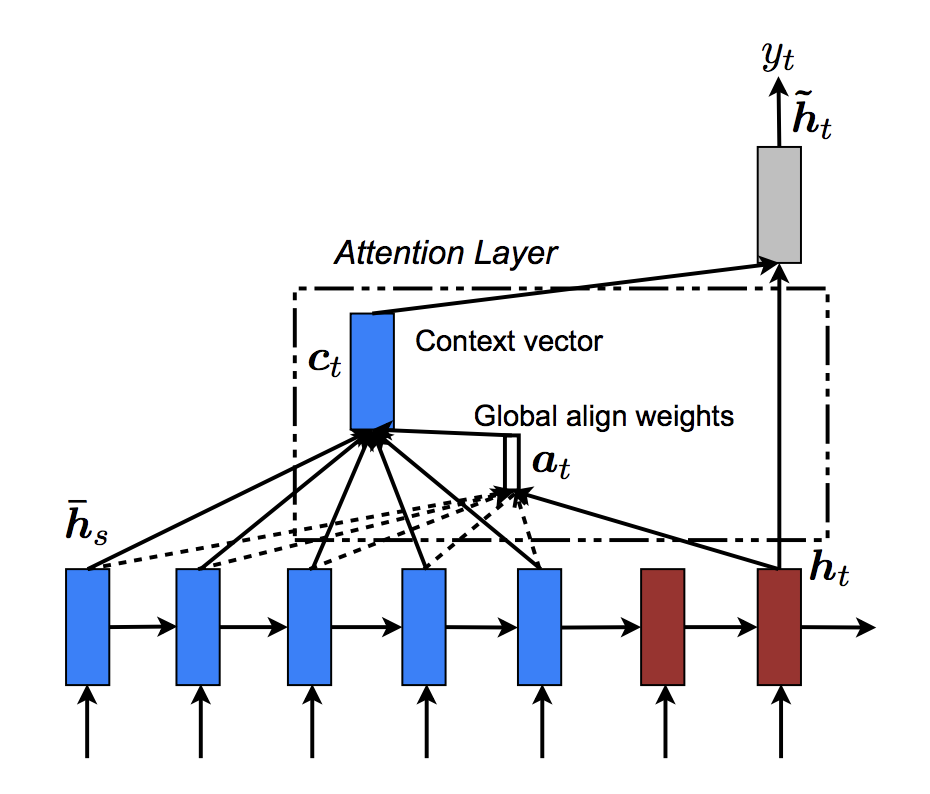

In [44]:
Image("https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/10/Depiction-of-Global-Attention-in-an-Encoder-Decoder-Recurrent-Neural-Network.png")

The attention module is like a convolutional layer that provides both high and low level context for the model.

In [54]:
class Attention(nn.Module):
    def __init__(self, method, hidden_size):
        super().__init__()
        self.method = method
        self.hidden = hidden
   
    def dotScore(self, hidden, enc_output):
        # Dot product over hidden size and word dimension is broadcasted
        return torch.sum(hidden, enc_output, dim = 2)
    
    def forward(self, hidden, enc_output):
        # hidden shape : (1, batch_size, hidden_size)
        # encoder : (sentence_len, batch_size, hidden_size)
        attention_energies = self.dot_score(hidden, enc_output) # (sentence_len, batch_size)
        attention_energies = attention_energies.t() # (batch_size, sentence_len)
        return F.softmax(attention_energies, dim = 1).unsqueeze(1) # (batch_size, 1, sentence_len)

Finally put it all togehter. In the decoder module?

In [58]:
class DecoderRNN(nn.Module):
    def __init__(self, att_model, encoder, hidden_size, output_size, n_layers = 1, dropout = 0.05):
        super().__init__()
        self.att_model = att_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.encoder = encoder
        self.encoder_dropout = nn.Dropout(dropout)
        gru_dropout = 0 if n_layers == 1 else dropout
        self.decoder_gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout = gru_dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        self.attention = Attention(att_model, hidden_size)
        
    def forward(self, input_step, prev_hidden, current_encoded_outputs):
        # encode
        encoded = self.encoder(input_step)
        encoded = self.encoder_dropout(embedded)
        # decode using previous hidden state and encode
        rnn_output, hidden = self.decoder_gru(encoded, prev_hidden)
        # Create attention weights representation
        attn_weights = self.attention(rnn_output, current_encoded_outputs)
        # Concatenate context and latest rnn output 
        context = attn_weights.bmm(current_encoded_outputs.transpose(0, 1))
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        # regular deep network form here forward 
        concat_output = torch.tanh(self.concat(concat_input))
        output = self.out(concat_output)
        output = F.softmax(output, dim = 1) # look at removing this
        return output, hidden

## Other objects for the training

## Training Loop